In [1]:
from tqdm import tqdm
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ast
import random

# Importing data from file

In [2]:
# Read data from ./coauthorship/coauthorship_cond-mat/cond-mat.net
A = np.zeros((16726,16726))
with open("./coauthorship/coauthorship_cond-mat/cond-mat.net", "r") as data_file:
    for line in data_file.readlines():
        i, j = [int(k) for k in line.split()]
        A[i,j] = 1
        A[j,i] = 1
        
D = np.zeros(A.shape)
for i in range(A.shape[0]):
    D[i,i] = np.sum(A[i])

In [3]:
# Determining which nodes are in the largest component using DFS
def connected_component(A, i): # A: adjacency matrix, i: node to find component
    visited = []
    S = []
    S.append(i)
    while(len(S) > 0):
        v = S.pop()
        print(len(visited))
        if(v not in visited):
            visited.append(v)
            for d in range(A.shape[0]):
                if(A[v][d] == 1):
                    S.append(d)
                
    return visited

# We can use NetworkX instead for speed.
G = nx.convert_matrix.from_numpy_array(A)
C_n = max(nx.connected_components(G))
C = G.subgraph(C_n)

In [4]:
len(C.edges()) # How many edges are in the graph?

44619

In [5]:
len(C.nodes()) # How many nodes are in the graph?

13861

# Computing $L_i$ and its distribution

Note that $\displaystyle L_i=\frac{1}{N-1}\sum_{j\ne i}d_{ij}$, where $d_{ij}$ is the distance between nodes $i$ and $j$.
Futhermore, note that $\displaystyle c_i = \begin{cases}\frac{K[G_i]}{k_i(k_i-1)/2} & k_i \ge 2 \\ 0 & k_i = 0,1\end{cases}$, where $K[G_i] = \displaystyle \frac{1}{2}(A^3)_{ii}$ and $k_i=D_{ii}$ is the degree of node $i$.

In [4]:
# Average path length
L_i = dict([(k, np.average(list(nx.shortest_path_length(C,k).values()))) for k in tqdm(C_n)])

# Save L_i values (25m to calculate)
with open("./coauthorship/coauthorship_cond-mat/average-dist.txt", "w+") as dist_file:
    dist_file.write(str(L_i))
    dist_file.close()

100%|██████████| 13861/13861 [49:06<00:00,  4.70it/s]    


In [6]:
# Alternatively, read from existing file for L_i.
with open("./coauthorship/coauthorship_cond-mat/average-dist.txt", "r") as dist_file:
    L_i = ast.literal_eval(dist_file.readline())
    dist_file.close()

In [7]:
# local clustering coefficient
c_i = nx.clustering(G)

In [8]:
# Calculate L = (1/N) ∑ L_i, the characteristic path length
L_avg = np.average(list(L_i.values()))

# Calculate C = (1/N) ∑ c_i, the clustering coefficient of the graph
C_avg = np.average(list(c_i.values()))

# Calculate D_avg = (1/N) ∑ d_i, the degrees of the nodes in the graph
D_dist = [D[i,i] for i in C_n]
D_avg = np.average(D_dist)

L_avg, C_avg, D_avg

(6.62735073477655, 0.6203627534751613, 6.438063631772599)

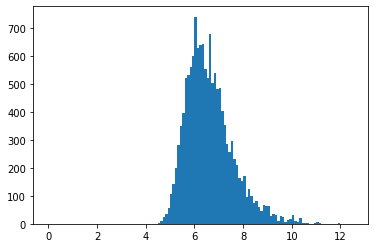

In [9]:
%matplotlib inline
# Plot L_i (characteristic length) distribution as histogram.
plt.hist(L_i.values(), bins=np.linspace(0,12.5,126))
plt.show()

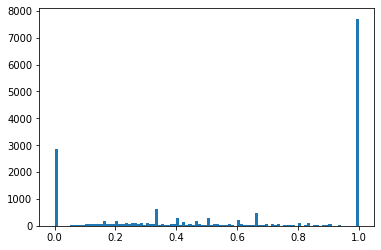

In [10]:
%matplotlib inline
# Plot c_i (local clustering coefficient) distribution as histogram.
plt.hist(c_i.values(), bins=np.linspace(0,1,101))
plt.show()

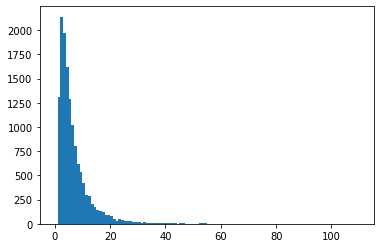

In [11]:
%matplotlib inline
# Plot D_dist (degree) distribution as histogram.
plt.hist(D_dist, bins=np.linspace(0,110,111))
plt.show()

# Exponential vs. power law distributions

We first analyze a plot of degree and local clustering coefficient, revealing that the graph of $c_i$ (average local clustering coefficient for degree $k_i$) over $k_i$ (degree) has a power law distribution with exponent approximately equal to $-1$.

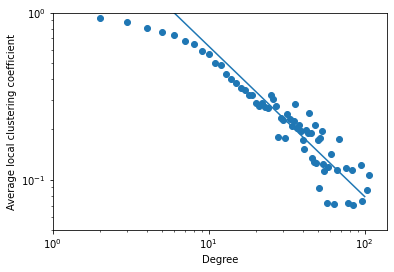

In [12]:
# Calculating averages per degree for the below plot (for average local clustering coefficient)
degree_coef = [(D[index, index], coef) for (index, coef) in c_i.items()]

coef_by_degree = {degree: [] for degree, _ in degree_coef}

for degree, coef in degree_coef:
    coef_by_degree[degree].append(coef)

for degree in coef_by_degree.keys():
    coef_by_degree[degree] = np.average(coef_by_degree[degree])

degree_coef_x, degree_coef_y = zip(*list(coef_by_degree.items()))

c_power_law_x = np.linspace(1,100,101)
c_power_law_y = 5*c_power_law_x**(-0.9) # 5*d^(-0.9)

plt.axis((1,140,0.05,1))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Average local clustering coefficient")
plt.scatter(degree_coef_x, degree_coef_y)
plt.plot(c_power_law_x, c_power_law_y)
plt.show()

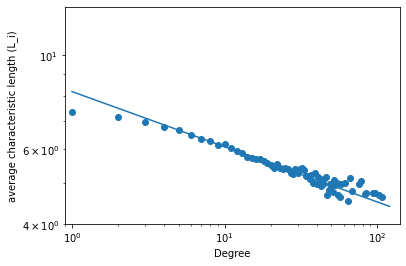

In [13]:
# Similarly, calculating averages per degree for the below plot (for average characteristic length)
degree_dist = [(D[index, index], dist) for (index, dist) in L_i.items()]

dist_by_degree = {degree: [] for degree, _ in degree_dist}

for degree, dist in degree_dist:
    dist_by_degree[degree].append(dist)

for degree in dist_by_degree.keys():
    dist_by_degree[degree] = np.average(dist_by_degree[degree])

degree_dist_x, degree_dist_y = zip(*list(dist_by_degree.items()))

L_power_law_x = np.linspace(1,120,121)
L_power_law_y = 8.2*L_power_law_x**(-0.13) # 8.2*d^(-0.13)

plt.axis((0.9,140,4,13))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("average characteristic length (L_i)")
plt.scatter(degree_dist_x, degree_dist_y)
plt.plot(L_power_law_x, L_power_law_y)
plt.show()

# Examining $L$ and $C$ for sampled subgraphs

We first examine the distribution of $C$ for sampled subgraphs of the largest component of the `cond-mat` dataset. We propose multiple different methods for sampling subgraphs.
- Start at a random node, and take a random walk 
- Sample a set of nodes, then find the shortest paths to connect each disconnected component and add those to the subgraph.

distance determining whether there is a node.

Sampling depending on centrality (higher centrality gets picked more often?)

Use graph characteristics to determine sampling.

### Results
Note that the most frequent characteristic length in the distribution is zero, because there exists no path between the given node and the other sampled nodes in the induced subgraph of the sampled nodes. In other words, the graph is split into a large number of components (approximately equal to the number of sampled nodes).

In [14]:
# Naive sampling process
C_n_sample = random.sample(C_n, 100)
C_sample = G.subgraph(C_n_sample)

In [15]:
# Calculating the L_i distribution of the sample in the *induced graph produced by the sampled nodes*
L_i_sample = dict([(k, np.average(list(nx.shortest_path_length(C_sample,k).values()))) for k in tqdm(C_n_sample)])

100%|██████████| 100/100 [00:00<00:00, 8595.59it/s]


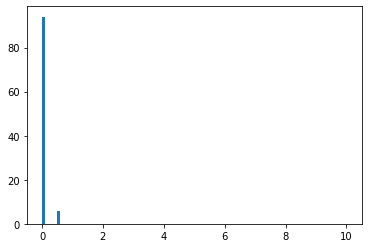

In [16]:
%matplotlib inline
# Plot L_i distribution as histogram.
plt.hist(L_i_sample.values(), bins=np.linspace(0,10,101))
plt.show()

In [17]:
print(np.average(list(L_i_sample.values())))

0.03


# Distribution of samples of $L_i$ for subset of nodes

We sample a subset of the ~14,000 nodes in the giant component of the *cond-mat* dataset and calculate the average length between a node in the sample and the rest of the nodes in the sample.

In [24]:
sample_L_n = random.sample(C_n, 200)

sample_L = [np.average([nx.shortest_path_length(C,s,t) for t in sample_L_n]) for s in tqdm(sample_L_n)]

100%|██████████| 200/200 [00:22<00:00,  8.78it/s]


This produces the following approximation.

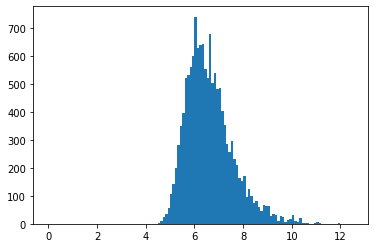

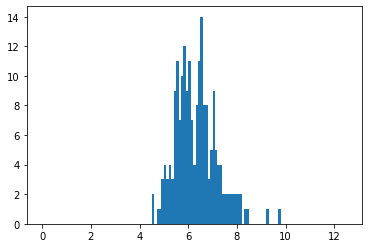

In [25]:
%matplotlib inline
# Plot L_i distribution as histogram, as compared to the sampled L_i distribution developed above.

plt.hist(L_i.values(), bins=np.linspace(0,12.5,126))
plt.show()

plt.hist(sample_L, bins=np.linspace(0,12.5,126))
plt.show()

In [26]:
# Calculating the L^2-norm on the sampled distribution vs. the actual distribution.
L_graph = np.histogram([k for k in list(L_i.values())], bins=np.linspace(0,12.5,51),density=True)
L_prob = L_graph[0]

L_sample_graph = np.histogram(sample_L, bins=np.linspace(0,12.5,51),density=True)
L_sample_prob = L_sample_graph[0]

np.sum((L_sample_prob-L_prob)**2)**(1/2)

0.29734357492957897

# Using simulated annealing to find coauthorship approximations

Lp spaces as an objective function!
Using the WS model to approximate the provided graph?

~~Because the small world model describes the characteristic path length growing as $\log(N)$, I used WolframAlpha to solve for $k$ in the equation $\log_k(N)=C_{avg}$ for the given dataset and determined $\log_k(50)/C_{avg}$ as a scaling factor for the histogram.~~

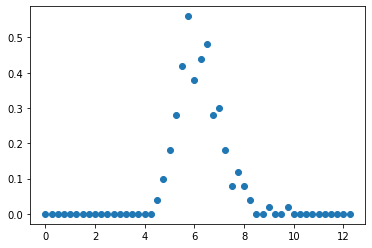

In [27]:
L_graph = np.histogram([k for k in list(L_i.values())], bins=np.linspace(0,12.5,51),density=True)
L_prob = L_graph[0]

L_sample_graph = np.histogram(sample_L, bins=np.linspace(0,12.5,51),density=True)
L_sample_prob = L_sample_graph[0]

plt.scatter(L_sample_graph[1][:len(L_sample_graph[0])], L_sample_graph[0])
plt.show()

## Move selection
Moves were selected by either adding or removing an edge from the graph, making sure that all proposed moves maintain connectedness in the graph.

The energy function selected was an $L^2$-norm function, although this can be easily switched to an $L^p$ norm.

Finally, the acceptance probability selected was $\min(1.0, e^{-\Delta E/(T+\varepsilon)})$, where $\varepsilon$ is a small positive constant.

In [28]:
def select_move(G):
    RE = list(filter(None.__ne__, [("remove", e) if nx.edge_connectivity(G, s=e[0], t=e[1])>1 else None for e in G.edges()]))
    RE = random.sample(RE, len(RE))[:min(10,len(RE))]
    #RE = []
    AE = random.sample([("add", e) for e in nx.non_edges(G)], len(G)*(len(G)-1)//2 - len(G.edges()))[:10]
    #AE = []
    #SE = random.sample([("swap", a, b) for a, b in zip(G.edges(), nx.non_edges(G))], LENGTH)[:10]
    SE = []
    return random.choice(RE + AE + SE)

def energy_function(G):
    GL_i = np.array([np.average(list(nx.shortest_path_length(G,k).values())) for k in G.nodes()])
    GL_prob = np.histogram(GL_i, bins=np.linspace(0,12.5,51),density=True)[0]
    return np.sum((GL_prob-L_sample_prob)**2)**(1/2)

def final_energy_function(G): # With the full distribution
    GL_i = np.array([np.average(list(nx.shortest_path_length(G,k).values())) for k in G.nodes()])
    GL_prob = np.histogram(GL_i, bins=np.linspace(0,12.5,51),density=True)[0]
    return np.sum((GL_prob-L_prob)**2)**(1/2)
    
#We use discrete L_p spaces.
def acceptance_probability(G,G_new,T):
    return min(1.0, np.exp(-(energy_function(G_new)-energy_function(G))/(T+1e-12)))

## The simulated annealing algorithm
Below is the actual implementation of the simulated annealing algorithm.

1
50


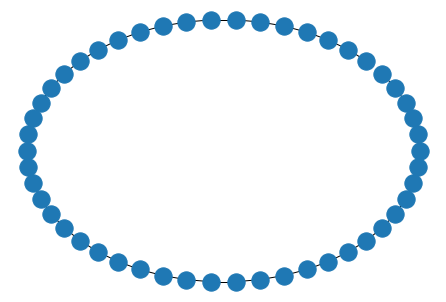

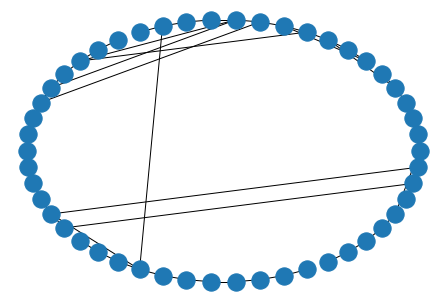

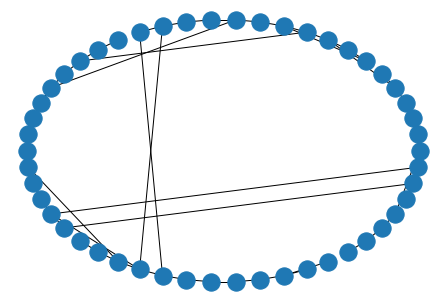

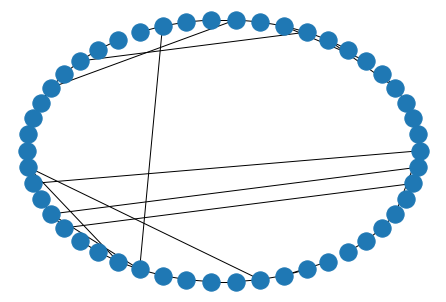

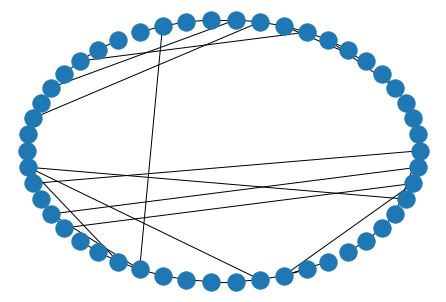

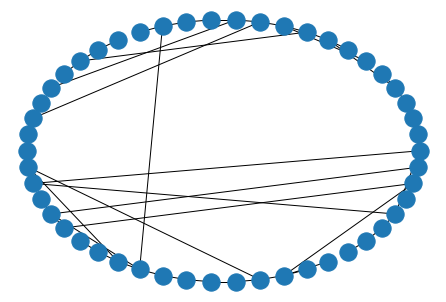

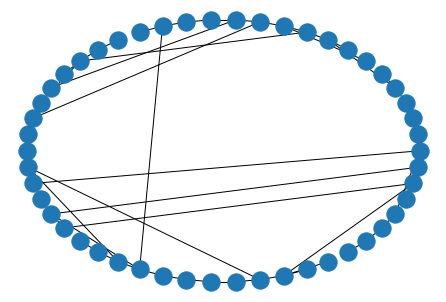

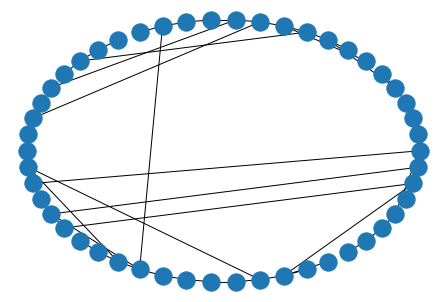

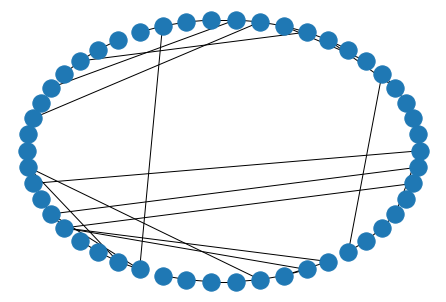

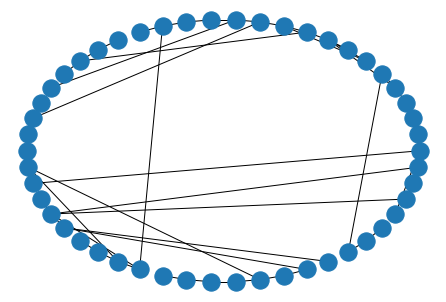

In [91]:
# Start with a WS or circle graph.
STEPS = 500
TEMPERATURE = 4e-2
energy_time = []

SA = nx.generators.random_graphs.watts_strogatz_graph(50,2,0.00) # Initialize the WS/circle graphs.
print(len(list(nx.connected_components(SA)))) # Should be connected initially.
print(len(SA.edges()))

best_graph = SA
min_energy = float("inf")
      
for step in range(STEPS):
    move = select_move(SA)
    SA_new = SA.copy()
    if(move[0] == "add"): # Perform the proposed move and test the energy of the updated graph.
        SA_new.add_edge(move[1][0], move[1][1])
    if(move[0] == "remove"):
        SA_new.remove_edge(move[1][0], move[1][1])
    if(move[0] == "swap"):
        SA_new.remove_edge(move[1][0], move[1][1])
        SA_new.add_edge(move[2][0], move[2][1])
    
    if(random.random() < acceptance_probability(SA, SA_new, TEMPERATURE)): # Calculate acceptance probability and change/maintain graph state.
        SA = SA_new
        
    TEMPERATURE -= TEMPERATURE/STEPS # Decrease temperature.
    
    if(energy_function(SA) < min_energy): # Record graph with lowest energy so far.
        min_energy = energy_function(SA)
        best_graph = SA.copy()

    energy_time.append(energy_function(SA)) # Add energy at step `step` (variable name) and plot below.
    if(step % 50 == 0): # Draw current graph to the screen every 50th step.
        nx.draw_circular(SA)
        plt.show()

## Graph energy over time
Below is a plot of the discrete $L^p$-norm between the approximated and sampled characteristic length distribution over time. Lower is better.

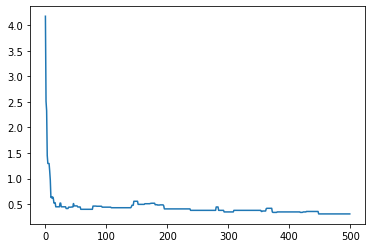

In [92]:
%matplotlib inline

plt.plot(energy_time)
plt.show()

## Visual comparisons of the actual and approximated characteristic length distributions

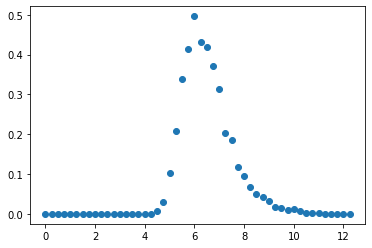

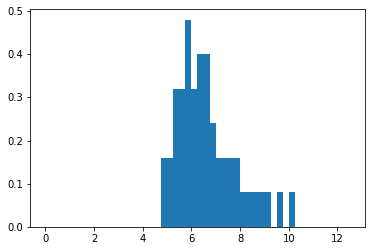

In [93]:
best_graph_max_conn = best_graph.subgraph(max(nx.connected_components(best_graph)))
best_graph_i = np.array([np.average(list(nx.shortest_path_length(best_graph_max_conn,k).values())) for k in best_graph_max_conn.nodes()])

plt.scatter(L_graph[1][:len(L_graph[0])], L_graph[0])
plt.show()
# Plot SA L_i distribution as histogram.

plt.hist(best_graph_i, bins=np.linspace(0,12.5,51), density=True)
plt.show()

In [94]:
len(best_graph_max_conn.edges()) # How many edges are in the approximated graph?

52

# Viewing the approximated graphs
(generated by simulated annealing)

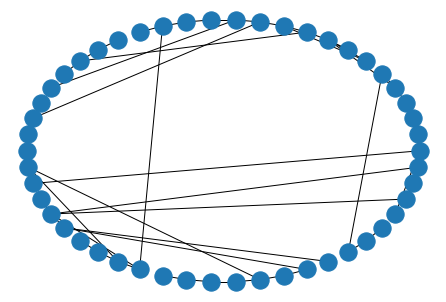

In [95]:
nx.draw_circular(best_graph_max_conn)

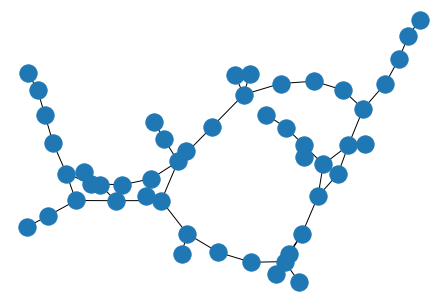

In [96]:
nx.draw(best_graph_max_conn)

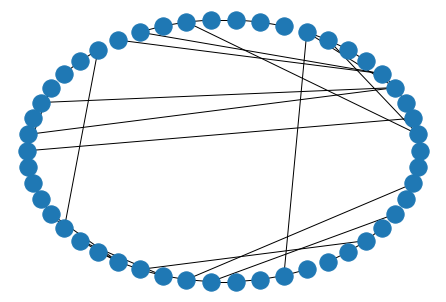

In [97]:
nx.draw_shell(best_graph_max_conn)

## Graph performance metrics using $L^p$-norms

In [98]:
min_energy # L^2 norm between the approximated and sampled characteristic length distributions

0.30983866769659335

In [99]:
final_energy_function(best_graph) # L^2 norm between the approximated and *actual* characteristic length distributions

0.3588514840620195

# Does the clustering coefficient and degree distribution align with the original graph?
No, unfortunately.

## Local clustering coefficient distribution comparison

In [100]:
best_graph_clustering_i = nx.clustering(best_graph_max_conn)
best_graph_C_avg = np.average(list(best_graph_clustering_i.values()))
best_graph_C_avg # the clustering coefficient for the best approximated graph.

0.0

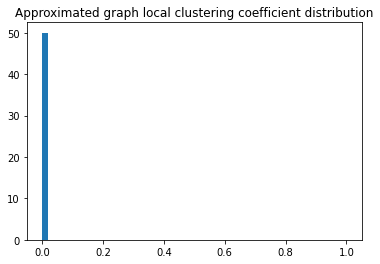

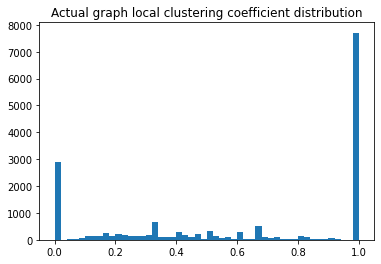

In [101]:
%matplotlib inline
plt.hist(best_graph_clustering_i.values(), bins=np.linspace(0,1,51))
plt.title("Approximated graph local clustering coefficient distribution")
plt.show()

plt.hist(c_i.values(), bins=np.linspace(0,1,51))
plt.title("Actual graph local clustering coefficient distribution")
plt.show()

## Degree distribution comparison

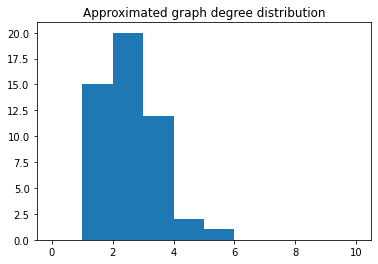

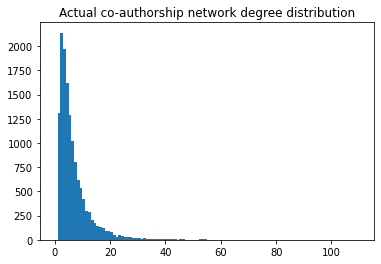

In [102]:
# Calculate D_avg = (1/N) ∑ d_i, the degrees of the nodes in the graph
best_graph_D_dist = [d for n, d in best_graph.degree()]

# Plot degree distribution as histogram.
plt.hist(best_graph_D_dist, bins=np.linspace(0,10,11))
plt.title("Approximated graph degree distribution")
plt.show()

# Plot D_dist (degree) distribution as histogram.
plt.hist(D_dist, bins=np.linspace(0,110,111))
plt.title("Actual co-authorship network degree distribution")
plt.show()

In [103]:
# L (characteristic path length) for the approximated graph
np.average(best_graph_i)

6.635999999999999

In [104]:
# The diameter of the approximated graph
nx.diameter(best_graph)

18